# 데이터셋 

2013년 1월 부터 2015년 10월까지의 일간 데이터를 가지고 적합. 그후 2015년 11월의 매출을 예측 

트랙 1: 일간 데이터로 예측을해서 2015년 11월의 일간 데이터를 예측하고 합해서 월간 매출을 예상한다.

트랙 2: 처음부터 월간 매출로 더한뒤에 매달 월간 매출을 예측한다. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./../data/item_categories.csv
./../data/sales_train.csv
./../data/items_en.csv
./../data/shops.csv
./../data/sample_submission.csv
./../data/items.csv
./../data/item_categories_en.csv
./../data/test.csv
./../data/shops_en.csv


In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


from warnings import filterwarnings
filterwarnings('ignore')

In [10]:
item_cats=pd.read_csv('./../data/item_categories.csv')
items = pd.read_csv('./../data/items.csv')
train=pd.read_csv('./../data/sales_train.csv')
shops = pd.read_csv('./../data/shops.csv')
test = pd.read_csv('./../data/test.csv')
sample_submission = pd.read_csv('./../data/sample_submission.csv')

In [12]:
train["date"]=pd.to_datetime(train["date"])

각 일별로 grouping한 뒤에 item, "item_cnt_day"을 더한 뒤 나타내 보았습니다. 

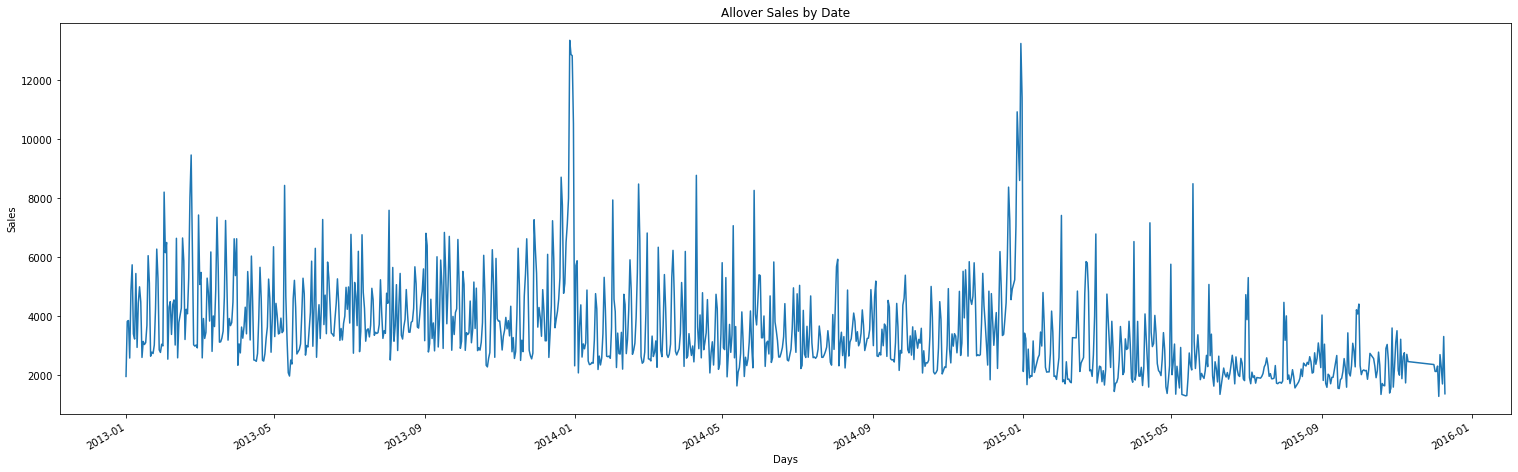

In [16]:
allover_sales_by_date = train.groupby(["date"])["item_cnt_day"].sum()
allover_sales_by_date.plot(kind="line",
                     xlabel="Days",
                     ylabel="Sales",
                     title= "Allover Sales by Date",
                     figsize=(26,8));

In [ ]:
저는 이 일간 데이터를 통해서 전체적인 plot의 형태를 살펴보고 싶습니다. 

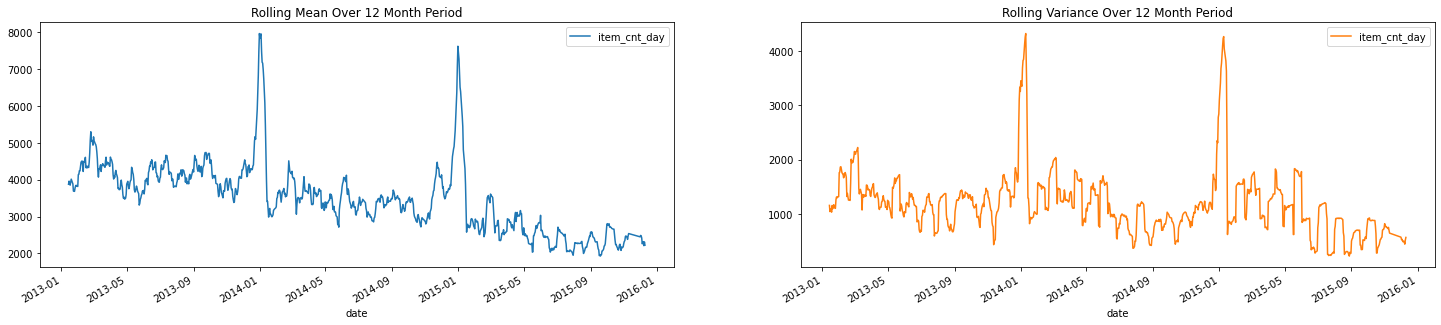

In [18]:
plt.subplot(121)
allover_sales_by_date.rolling(window = 14).mean().plot(figsize=(25,5), 
                                                 color="tab:blue", 
                                                 title="Rolling Mean Over 12 Month Period", 
                                                 legend = True);
plt.subplot(122)
allover_sales_by_date.rolling(window = 14).std().plot(color="tab:orange", 
                                                title="Rolling Variance Over 12 Month Period", 
                                                legend=True);


2주간의 평균,과 분산을 통해 확실한 seasonality과 분산의 변동을 확인할 수 있었습니다.                  
일간을 통해서 확인할 수 있었던 점은 2015년 11월의 분산이 오히려 작아지는 영향이 있닫는 것입니다.                 
이는 월간 데이터를 통해서는 확인할 수 없었던 측면입니다.           


이때 일간 데이터이기때문에 seasonality를 어떻게 놓을지에 대해서 고민하게 되었습니다.              
월마다 seaonalirty를 30일로 잡으면 각 달안에서의 seasonality을 잡아낼수있습니다.             
그러나 연말에 상승하는 sales은 trend로 잡히게 되고 
이는 우리 분석에 있어서 중대한 영향을 미치는 11월, 12월에 상승하는 sales를  잡지 못하게 될것이기 떄문입니다.

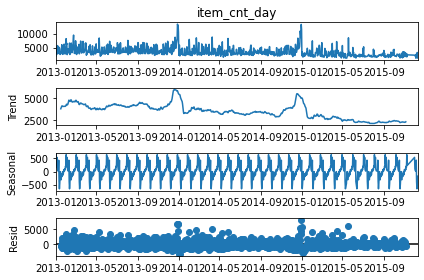

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose # seasonality 주기 30 

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 30, model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();


이때 일간 데이터이기때문에 seasonality를 어떻게 놓을지에 대해서 고민하게 되었습니다.           
월마다 seaonalirty를 30일로 잡으면 각 달안에서의 seaonalirty을 잡아낼수있습니다.                            
그러나 연말에 상승하는 매출은 trend로 잡히게 됩니다.              
이는 우리 분석에 있어서 중대한 영향을 미치는 월말 매출급등을 잡지 못하게 될것이기 떄문입니다.

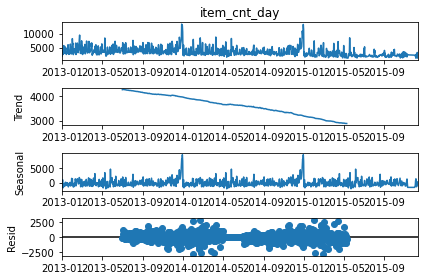

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose #계절성 주기 365

decompose_result = seasonal_decompose(allover_sales_by_date, freq= 365 , model="additive")
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

반대로 계절성 주기를 365로 잡으면 위와 같이 계산할 수 있습니다.        
매년안에서의 계절성을 잡아낼수 있게 됩니다.             
그러나 우리의 데이터가 2013,2014,2015년 일부의 데이터이기때문에                 

seasonality를 계산함에 있어서 365로 계산했을때 각 365번의 주기가 2번, 3번밖에 돌지않습니다.         
즉 겨우 2번, 3번의 기회로 seasonaltiy를 계산하게 됩니다. 

즉 우리가 추정한 seasoanlity의 추정이 상대적으로 안정되지않은 값을 가지게 된다는 단점이 있습니다. 